# Model Evaluation

<font color='green'>Notebook used to evaluate the trained models.</font>

---
### 1. Data Retrieval and Sanitization
- Training, Validation and Test Set Retrieval
- Text Sanitization
- Label Indexing
---

### 2. Feature Engineering
- Sequence Vectorization
1. Tokenize Text
2. Texts to Sequences
3. Pad Sequences

- Embeddings
1. Load Pre-Trained Embeddings
2. Embedding matrix
---
### 3. Model Definitions
- Decomposable Attention Model by Perikh et al. (DAM)
- Decomposable Attention Model with Intra-Sentence Attention (DAM-INTRA)
- Decomposable Attention Model with BiLSTM (DAM-BiLSTM)
- Decomposable Attention Model with BiGRU (DAM-BiGRU)
---
### 4. Model Evaluation
- Load Model Weights
- Predictions
- Quantitative Evaluation
    1. Classification Report
    2. Confusion Matrix
    3. ROC Curve
    4. Precision-Recall Curve

- Qualitation Evaluation
    1. Observation of Incorrect Predictions
    2. Custom Input Predictions
---

In [1]:
# For File Handling
import csv
import os

# For Data
import pandas as pd
import numpy as np

# For Processing
import re
import nltk
import string

# For Plotting
#%matplotlib inline
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
import seaborn as sns
import sklearn.metrics as metrics

# For Word Embeddings
import gensim
import gensim.downloader as gensim_api

# For Deep Learning
import tensorflow as tf
from tensorflow.keras import Model, models, layers, preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# Miscellaneous 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data directories
dataset_dir = "dataset"
saved_models_dir = "saved-models"

# SNLI dataset files
snli_train_file = "dataset/snli_1.0_train.txt"
snli_val_file = "dataset/snli_1.0_dev.txt"
snli_test_file = "dataset/snli_1.0_test.txt"

# Saved Model files
dam_save_file = "saved-models/dam_weights.hdf5"
dam_intra_save_file = "saved-models/dam_intra_weights.hdf5"
dam_bilstm_save_file = "saved-models/dam_bilstm_weights.hdf5"
dam_bigru_save_file = "saved-models/dam_bigru_weights.hdf5"

In [3]:
# Since tensorflow gpu is being used
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

# 1. Data Retrieval and Sanitization

In [4]:
try:
    assert os.path.exists(dataset_dir)
    assert os.path.exists(snli_train_file)
    assert os.path.exists(snli_val_file)
    assert os.path.exists(snli_test_file)
except:
    print("Assertion failed: Run dataset-utils.ipynb to initialise dataset files")

### Training, Validation and Test Set Retrieval

In [5]:
def get_data(data_file):
    
    if os.path.exists(data_file):
        with open(data_file,"r") as open_file:
            csv_file = csv.DictReader(open_file, delimiter='\t')

            premise_sentences = []
            hypothesis_sentences = []
            gold_labels = []

            for row in csv_file:
                
                # Skip rows if label is not definite
                if row["gold_label"] != "-":
                    premise_sentences.append(row["sentence1"])
                    hypothesis_sentences.append(row["sentence2"])
                    gold_labels.append(row["gold_label"])

            return premise_sentences, hypothesis_sentences, gold_labels


train_dict = dict()
val_dict = dict()
test_dict = dict()

# Store data in respective dictionaries
train_dict['premise'], train_dict['hypothesis'], train_dict['label'] = get_data(snli_train_file)
val_dict['premise'], val_dict['hypothesis'], val_dict['label'] = get_data(snli_val_file)
test_dict['premise'], test_dict['hypothesis'], test_dict['label'] = get_data(snli_test_file)

# Create Pandas dataframes for each set
train_df = pd.DataFrame(train_dict)
val_df = pd.DataFrame(val_dict)
test_df = pd.DataFrame(test_dict)

### Text Sanitization

In [6]:
def sanitize_text(text):

    # Remove punctuation and lower case
    sanitized_text = re.sub(r'[^\w\s]', '', str(text).lower().strip()) 
    return sanitized_text

# Clean Train data
train_df["premise_clean"] = train_df["premise"].apply(lambda x: sanitize_text(x))
train_df["hypothesis_clean"] = train_df["hypothesis"].apply(lambda x: sanitize_text(x))

# Clean Validation data
val_df["premise_clean"] = val_df["premise"].apply(lambda x: sanitize_text(x))
val_df["hypothesis_clean"] = val_df["hypothesis"].apply(lambda x: sanitize_text(x))

# Clean Test data
test_df["premise_clean"] = test_df["premise"].apply(lambda x: sanitize_text(x))
test_df["hypothesis_clean"] = test_df["hypothesis"].apply(lambda x: sanitize_text(x))

### Label Indexing

In [7]:
label_index = {
    "entailment":0,
    "neutral":1,
    "contradiction":2,
}

def indexify_label(label):
    return label_index[label]

test_df["label_index"] = test_df["label"].apply(lambda x: indexify_label(x))

# 2. Feature Engineering

### Sequence Vectorisation

#### 1. Tokenize Text

In [8]:
# Tokenize text
all_train_text = list(train_df['premise_clean']) + list(train_df['hypothesis_clean']) + list(val_df['premise_clean']) + list(val_df['hypothesis_clean'])

tokenizer = preprocessing.text.Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(all_train_text)
word_index = tokenizer.word_index

#### 2. Texts to Sequences

In [9]:
def texts_to_sequences(texts):
    return tokenizer.texts_to_sequences(texts)

test_sequence_dict = dict()

# Create Test sequences
test_sequence_dict['premise'] = texts_to_sequences(test_df['premise_clean'])
test_sequence_dict['hypothesis'] = texts_to_sequences(test_df['hypothesis_clean'])

#### 3. Pad Sequences

In [10]:
# Max sequence length set to 50 instead of max sentence length (78) to avoid sparsity in vectors
# Full explanation on data-visualizer.ipynb
max_sequence_len = 50

In [11]:
def pad_sequences(sequences, maxlen):
    return preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")

# Pad Test Sequences
test_sequence_dict['premise_padded'] = pad_sequences(test_sequence_dict['premise'], maxlen=max_sequence_len)
test_sequence_dict['hypothesis_padded'] = pad_sequences(test_sequence_dict['hypothesis'], maxlen=max_sequence_len)

In [12]:
print("Premise original text:\n",test_df['premise'][0])
print("\n")
print("Premise clean text:\n",test_df['premise_clean'][0])
print("\n")
print("Premise sequence:\n",test_sequence_dict['premise'][0])
print("\n")
print("Premise sequence padded:\n",test_sequence_dict['premise_padded'][0])

Premise original text:
 This church choir sings to the masses as they sing joyous songs from the book at a church.


Premise clean text:
 this church choir sings to the masses as they sing joyous songs from the book at a church


Premise sequence:
 [213, 594, 1244, 712, 15, 3, 12775, 55, 135, 1360, 5980, 3253, 58, 3, 287, 16, 2, 594]


Premise sequence padded:
 [  213   594  1244   712    15     3 12775    55   135  1360  5980  3253
    58     3   287    16     2   594     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


### Embeddings

#### 1. Load Pre-Trained Embeddings
To ensure the best results, a pre-trained model for embedding was used. Alternatively, a model could have also been trained using the SNLI dataset. However, by using the word2vec-google-news-300 model which contains information on about 100 billion words, more accurate vector contexts.

Link to gensim-data: https://github.com/RaRe-Technologies/gensim-data

In [13]:
embedding_model = gensim_api.load("word2vec-google-news-300")

#### 2. Embedding Matrix

In [14]:
# 300 vector size since using word2vec-google-news-300
vector_size = 300

# Length of vocabulary is added a 1 to account for the OOV token
len_vocab = len(word_index)+1

# Create embedding matrix (length of vocabulary x vector size)
embeddings = np.zeros((len_vocab, vector_size))

for word,idx in word_index.items():
    # Update embeddings with pre-trained vectors if word exists
    try:
        embeddings[idx] = embedding_model[word]
        
    # If word does not exist, skip
    except:
        pass

# 3. Model Definitions
Note: For model visualisations please refer to model-trainer.ipynb 

In [15]:
# Function to return an embedding layer
def embedding_layer(name, embeddings, num_nodes=16):
    return models.Sequential(
        [
            # Embedding Layer
            layers.Embedding(
                embeddings.shape[0],
                embeddings.shape[1],
                input_length=max_sequence_len,
                weights=[embeddings],
                trainable=False,
            ),
        ], name=name)


# Function to return a feed-forward layer
def feed_forward_layer(name, num_nodes=200, activation="relu", dropout_rate=0):
    return models.Sequential(
        [
            layers.Dense(num_nodes, activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(num_nodes, activation=activation),
            layers.Dropout(dropout_rate),
        ], name=name)


# Function to return BiLSTM layer
def bilstm_layer(name, num_nodes=200, activation="relu", dropout_rate=0):
    return layers.Bidirectional(
            layers.LSTM(num_nodes, return_sequences=True, dropout=dropout_rate, activation=activation),
        name=name)


# Function to return a BiGRU layer
def bigru_layer(name, num_nodes=200, activation="relu", dropout_rate=0):
    return layers.Bidirectional(
            layers.GRU(num_nodes, return_sequences=True, dropout=dropout_rate, activation=activation),
        name=name)


# Function to carry out normalisation for soft-alignment
def normalizer(axis):
    def _normalize(vector_similarities):
        exp_weights = K.exp(vector_similarities)
        sum_weights = K.sum(exp_weights, axis=axis, keepdims=True)
        return exp_weights / sum_weights

    return _normalize


# Function to return distance-sensitive bias terms for intra-sentence attention
def distance_terms(input_shape):
    
    time_steps = input_shape[1]
    distance_terms = np.zeros(shape=(time_steps, time_steps))
    for i in range(time_steps):
        for j in range(time_steps):
            distance_terms[i][j] = min(i-j, 10)
    
    #return K.variable(distance_terms)
    return distance_terms
        
    
# Function to carry out normalisation for intra-sentence attention
def intra_normalizer(axis, distance_terms):
    def _normalize(f_i_j):
        exp_weights = K.exp(f_i_j + distance_terms)
        sum_weights = K.sum(exp_weights, axis=axis, keepdims=True)
        return exp_weights / sum_weights

    return _normalize


# Function to sum and return an aggregated vector
def aggregater(x):
    return K.sum(x, axis=1, keepdims=False)

### Decomposable Attention Model by Perikh et al. (DAM)

In [16]:
# Function to combine layers together and return the final dam model
def build_dam_model(num_nodes, intra_sentence_attention=False):
    
    # Input Layer
    x1 = layers.Input(shape=(max_sequence_len,), name="Input_x1")
    x2 = layers.Input(shape=(max_sequence_len,), name="Input_x2")
    
    # Embedding Layer
    embedding = embedding_layer("Embedding", embeddings)
    e1 = embedding(x1)
    e2 = embedding(x2)
    
    input_a = e1
    input_b = e2
    
    if intra_sentence_attention:
        # Intra-Sentence Attention
        feedforward_intra = feed_forward_layer("FF_Intra", num_nodes, dropout_rate= 0.1)
        intra_a_i = feedforward_intra(e1)
        intra_a_j = feedforward_intra(e2)

        f_i_j = layers.dot([intra_a_i, layers.Permute((2,1))(intra_a_j)], axes=(2,1), name="Intra-Attention")

        # -> Distance Sensitive bias terms
        d_i_j = distance_terms(e1.shape)

        # -> Self-Aligned Phrases
        norm_i = layers.Lambda(intra_normalizer(1, d_i_j), name="Normalise_Similarities_i")(f_i_j)
        norm_j = layers.Lambda(intra_normalizer(2, d_i_j), name="Normalise_Similarities_j")(f_i_j)
        self_aligned_ai = layers.dot([norm_i, e1], axes=1, name="Self-Align_a_i")
        self_aligned_bi = layers.dot([norm_j, e2], axes=1, name="Self-Align_b_i")

        input_a = layers.concatenate([e1, self_aligned_ai], name="Concat_embedding_and_self-aligned_a")
        input_b = layers.concatenate([e2, self_aligned_bi], name="Concat_embedding_and_self-aligned_b")
        
    # Attend
    # -> Pass each word through a FFN with RelU activations to yield a non-linear transformation.
    feedforward_F = feed_forward_layer("FF_F", num_nodes, dropout_rate= 0.1)
    x1_nonlinear = feedforward_F(input_a)
    x2_nonlinear = feedforward_F(input_b)
    
    # -> Compute pairwise word similarity between every word in x1 compared to every word in x2, and vice versa.
    vector_similarities = layers.dot([x1_nonlinear, layers.Permute((2,1))(x2_nonlinear)], axes=(2,1), name="Pairwise_Similarity")
    
    # -> Compute Soft-Attention
    norm_similarities_x1 = layers.Lambda(normalizer(1), name="Normalise_Similarities_x1")(vector_similarities)
    norm_similarities_x2 = layers.Lambda(normalizer(2), name="Normalise_Similarities_x2")(vector_similarities)
    alpha = layers.dot([norm_similarities_x2, e1], axes=1, name="Alpha")
    beta = layers.dot([norm_similarities_x1, e2], axes=1, name="Beta")
        
    # Compare
    feedforward_G = feed_forward_layer("FF_G", num_nodes, dropout_rate= 0.1)
    comp1 = layers.concatenate([e1, beta], name="Concat_x1_beta")
    comp2 = layers.concatenate([e2, alpha], name="Concat_x2_alpha")
    
    v1 = feedforward_G(comp1)
    v2 = feedforward_G(comp2)
    
    # Aggregate
    v1_sum = layers.Lambda(aggregater, name="Aggregate_v1")(v1)
    v2_sum = layers.Lambda(aggregater, name="Aggregate_v2")(v2)
    concat = layers.concatenate([v1_sum, v2_sum], name="Concat_v1_v2")
    
    # Output Layer
    feedforward_H = feed_forward_layer("FF_H", num_nodes, dropout_rate= 0.1)
    y = feedforward_H(concat)
    y = layers.Dense(3, activation="softmax", name="Output")(y)
        
    model = Model(inputs=[x1, x2], outputs=y)
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer=Adam(lr=0.0005),
    )

    return model

In [17]:
dam_model = build_dam_model(200)
# To see model summary and architecture, refer to model-trainer.ipynb

In [18]:
### Decomposable Attention Model with Intra-Sentence Attention. (DAM-INTRA)

In [19]:
dam_intra_model = build_dam_model(200, intra_sentence_attention=True)
# To see model summary and architecture, refer to model-trainer.ipynb

### Decomposable Attention Model with BiLSTM. (DAM-BiLSTM)

In [20]:
# Function to combine layers together and return the final dam_bilstm model
def build_dam_bilstm_model(num_nodes):
      
    # Input Layer
    x1 = layers.Input(shape=(max_sequence_len,), name="Input_x1")
    x2 = layers.Input(shape=(max_sequence_len,), name="Input_x2")
    
    # Embedding Layer
    embedding = embedding_layer("Embedding", embeddings)
    e1 = embedding(x1)
    e2 = embedding(x2)
        
    # Attend
    # -> Pass each word through a FFN with RelU activations to yield a non-linear transformation.
    feedforward_F = feed_forward_layer("FF_F", num_nodes, dropout_rate= 0.1)
    x1_nonlinear = feedforward_F(e1)
    x2_nonlinear = feedforward_F(e2)
    
    # -> Compute pairwise word similarity between every word in x1 compared to every word in x2, and vice versa.
    vector_similarities = layers.dot([x1_nonlinear, layers.Permute((2,1))(x2_nonlinear)], axes=(2,1), name="Pairwise_Similarity")
    
    # -> Compute Soft-Attention
    norm_similarities_x1 = layers.Lambda(normalizer(1), name="Normalise_Similarities_x1")(vector_similarities)
    norm_similarities_x2 = layers.Lambda(normalizer(2), name="Normalise_Similarities_x2")(vector_similarities)
    alpha = layers.dot([norm_similarities_x2, e1], axes=1, name="Alpha")
    beta = layers.dot([norm_similarities_x1, e2], axes=1, name="Beta")
        
    # Compare
    comp1 = layers.concatenate([e1, beta], name="Concat_x1_beta")
    comp2 = layers.concatenate([e2, alpha], name="Concat_x2_alpha")
    
    # BiLSTM_G isntead of FFN_G
    bilstm_G = bilstm_layer("BiLSTM_G", num_nodes=num_nodes, dropout_rate= 0)
    v1 = bilstm_G(comp1)
    v2 = bilstm_G(comp2)
    
    # Aggregate
    v1_sum = layers.Lambda(aggregater, name="Aggregate_v1")(v1)
    v2_sum = layers.Lambda(aggregater, name="Aggregate_v2")(v2)
    concat = layers.concatenate([v1_sum, v2_sum], name="Concat_v1_v2")
    
    # Output Layer
    feedforward_H = feed_forward_layer("FF_H", num_nodes, dropout_rate= 0.1)
    y = feedforward_H(concat)
    y = layers.Dense(3, activation="softmax", name="Output")(y)
        
    model = Model(inputs=[x1, x2], outputs=y)
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer=Adam(lr=0.0005),
    )

    return model

In [21]:
dam_bilstm_model = build_dam_bilstm_model(200)
# To see model summary and architecture, refer to model-trainer.ipynb

### Decomposable Attention Model with BiGRU. (DAM-BiGRU)

In [22]:
# Function to combine layers together and return the final dam_bigru model
def build_dam_bigru_model(num_nodes):
      
    # Input Layer
    x1 = layers.Input(shape=(max_sequence_len,), name="Input_x1")
    x2 = layers.Input(shape=(max_sequence_len,), name="Input_x2")
    
    # Embedding Layer
    embedding = embedding_layer("Embedding", embeddings)
    e1 = embedding(x1)
    e2 = embedding(x2)
        
    # Attend
    # -> Pass each word through a FFN with RelU activations to yield a non-linear transformation.
    feedforward_F = feed_forward_layer("FF_F", num_nodes, dropout_rate= 0.1)
    x1_nonlinear = feedforward_F(e1)
    x2_nonlinear = feedforward_F(e2)
    
    # -> Compute pairwise word similarity between every word in x1 compared to every word in x2, and vice versa.
    vector_similarities = layers.dot([x1_nonlinear, layers.Permute((2,1))(x2_nonlinear)], axes=(2,1), name="Pairwise_Similarity")
    
    # -> Compute Soft-Attention
    norm_similarities_x1 = layers.Lambda(normalizer(1), name="Normalise_Similarities_x1")(vector_similarities)
    norm_similarities_x2 = layers.Lambda(normalizer(2), name="Normalise_Similarities_x2")(vector_similarities)
    alpha = layers.dot([norm_similarities_x2, e1], axes=1, name="Alpha")
    beta = layers.dot([norm_similarities_x1, e2], axes=1, name="Beta")
        
    # Compare
    comp1 = layers.concatenate([e1, beta], name="Concat_x1_beta")
    comp2 = layers.concatenate([e2, alpha], name="Concat_x2_alpha")
    
    # BiGRU_G isntead of FFN_G
    bigru_G = bigru_layer("BiGRU_G", num_nodes=num_nodes, dropout_rate= 0)
    v1 = bigru_G(comp1)
    v2 = bigru_G(comp2)
    
    # Aggregate
    v1_sum = layers.Lambda(aggregater, name="Aggregate_v1")(v1)
    v2_sum = layers.Lambda(aggregater, name="Aggregate_v2")(v2)
    concat = layers.concatenate([v1_sum, v2_sum], name="Concat_v1_v2")
    
    # Output Layer
    feedforward_H = feed_forward_layer("FF_H", num_nodes, dropout_rate= 0.1)
    y = feedforward_H(concat)
    y = layers.Dense(3, activation="softmax", name="Output")(y)
        
    model = Model(inputs=[x1, x2], outputs=y)
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
        optimizer=Adam(lr=0.0005),
    )

    return model

In [23]:
dam_bigru_model = build_dam_bigru_model(200)
# To see model summary and architecture, refer to model-trainer.ipynb

# 4. Model Evaluation

### Load Model Weights

In [24]:
# Load DAM weights if exists
if os.path.exists(dam_save_file):
    dam_model.load_weights(dam_save_file)
else:
    dam_model = None

# Load DAM-INTRA weights if exists
if os.path.exists(dam_intra_save_file):
    dam_intra_model.load_weights(dam_intra_save_file)
else:
    dam_intra_model = None
    
# Load DAM-BiLSTM weights if exists
if os.path.exists(dam_bilstm_save_file):
    dam_bilstm_model.load_weights(dam_bilstm_save_file) 
else:
    dam_bilstm_model = None
    
# Load DAM-BiGRU weights if exists
if os.path.exists(dam_bigru_save_file):
    dam_bigru_model.load_weights(dam_bigru_save_file) 
else:
    dam_bigru_model = None
    
models = {
    "DAM Model": dam_model,
    "DAM-INTRA Model": dam_intra_model,
    "DAM-BiLSTM Model": dam_bilstm_model,
    "DAM-BiGRU Model": dam_bigru_model,
}

### Predictions

In [25]:
# Function to apply model to test data and return predictions
def predict_data(model, data):
    softmax_predictions = model.predict(data)
    
    # If softmax prediction array is 3D remove middle dimension and make it 2D
    if(len(softmax_predictions.shape) >= 3):
        softmax_predictions = softmax_predictions[:, 0, :]
        
    index_predictions = np.argmax(softmax_predictions, axis=-1)
    predictions = (softmax_predictions, index_predictions)
    return predictions


predictions = dict()
test_data = [test_sequence_dict['premise_padded'], test_sequence_dict['hypothesis_padded']]
test_labels = test_df["label_index"]
label_classes = list(label_index.keys())
dummy_test = pd.get_dummies(test_labels, drop_first=False).values

for model_name, model in models.items():
    if model != None:
        predictions[model_name] = predict_data(model, test_data)
        print(model_name+" has made predictions.")
        
        score = model.evaluate(test_data, test_labels)
        print(f'Test loss: {score[0]} / Test accuracy: {score[1]}\n')

DAM Model has made predictions.
9824/9824 [==============================] - 1s 121us/sample - loss: 0.4065 - accuracy: 0.8477
Test loss: 0.40649779737966457 / Test accuracy: 0.8477198481559753

DAM-INTRA Model has made predictions.
9824/9824 [==============================] - 1s 152us/sample - loss: 0.4181 - accuracy: 0.8452
Test loss: 0.41805196058381267 / Test accuracy: 0.8451750874519348

DAM-BiLSTM Model has made predictions.
9824/9824 [==============================] - 6s 651us/sample - loss: 0.4094 - accuracy: 0.8455
Test loss: 0.4094188018225692 / Test accuracy: 0.8454804420471191

DAM-BiGRU Model has made predictions.
9824/9824 [==============================] - 7s 762us/sample - loss: 0.4015 - accuracy: 0.8471
Test loss: 0.4015242657851707 / Test accuracy: 0.8471091389656067



### Quantitative Evaluation

#### 1. Classification Reports

In [26]:
for model_name, preds in predictions.items():
    index_preds = preds[1]

    print("\n")
    print(model_name+" Report:")
    print(metrics.classification_report(test_labels, index_preds))



DAM Model Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3368
           1       0.80      0.80      0.80      3219
           2       0.88      0.86      0.87      3237

    accuracy                           0.85      9824
   macro avg       0.85      0.85      0.85      9824
weighted avg       0.85      0.85      0.85      9824



DAM-INTRA Model Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3368
           1       0.81      0.79      0.80      3219
           2       0.87      0.86      0.86      3237

    accuracy                           0.85      9824
   macro avg       0.84      0.84      0.84      9824
weighted avg       0.84      0.85      0.84      9824



DAM-BiLSTM Model Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3368
           1       0.80      0.81      0.80      3219
  

#### 2. Confusion Matrices

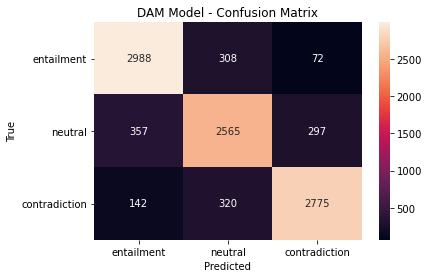

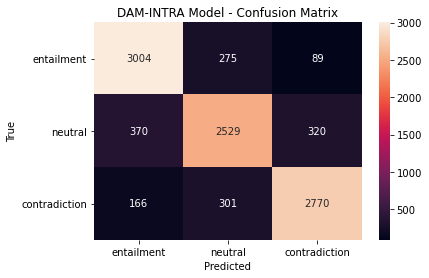

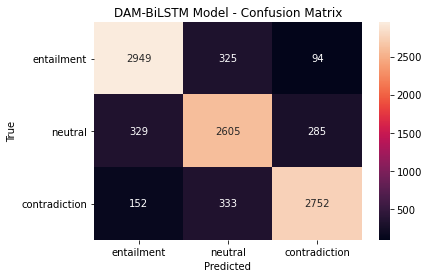

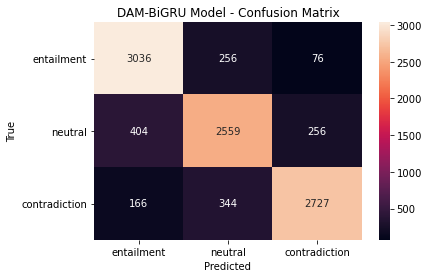

In [27]:
for model_name, preds in predictions.items():
    index_preds = preds[1]
    
    cm = metrics.confusion_matrix(test_labels, index_preds)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cbar=True)
    ax.set(xlabel="Predicted", ylabel="True", xticklabels=label_classes, yticklabels=label_classes, title=model_name+" - Confusion Matrix")
    plt.yticks(rotation=0)

#### 3.  ROC and Precision-Recall Curves

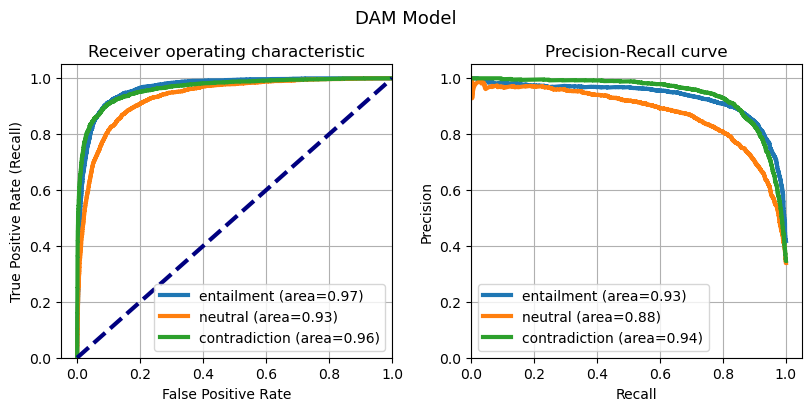

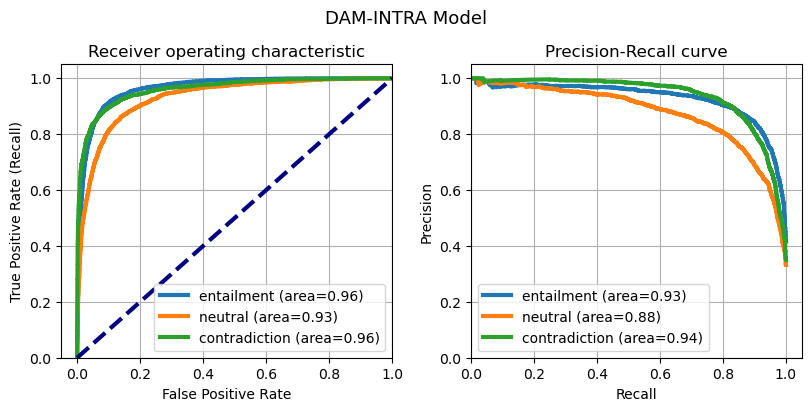

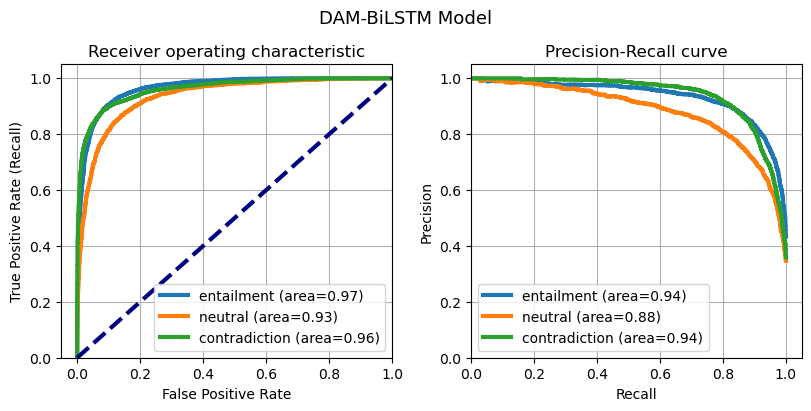

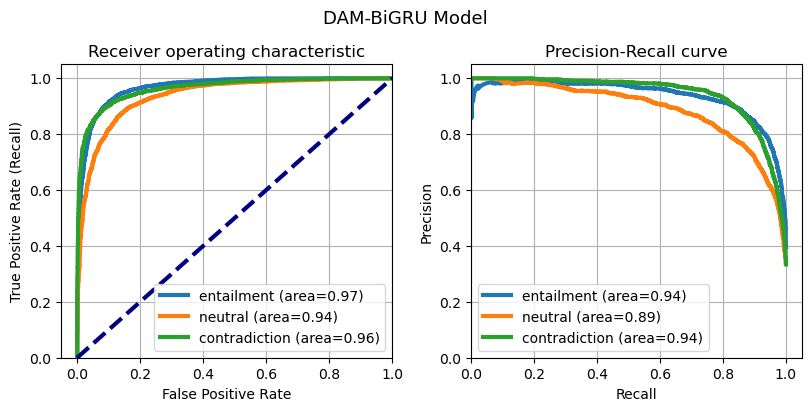

In [28]:
for model_name, preds in predictions.items():
    softmax_preds = preds[0]
    index_preds = preds[1]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8,4), dpi= 100)
    fig.suptitle(model_name, fontsize=13)
    
    # ROC Curve
    for i in range(len(label_classes)):
        fpr, tpr, thresholds = metrics.roc_curve(dummy_test[:,i], softmax_preds[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(label_classes[i], metrics.auc(fpr, tpr)))
    
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate',  ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    # Precision-Recall
    for i in range(len(label_classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(dummy_test[:,i], softmax_preds[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(label_classes[i], metrics.auc(recall, precision)))
    
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    
    
    plt.show()


### Qualitative Evaluation

#### 1. Observation of Incorrect Predictions
For each model, display an incorrect prediction done for each class.

In [29]:
def display_predictions(predictions, data_df, predictions_per_class=1, custom=False):
    for model_name, preds in predictions.items():
        softmax_preds = preds[0]
        index_preds = preds[1]
        
        # If not custom limit display and show gold label
        if custom == False:
            print("\n")
            print("\033[1m"+"Predictions On Test Set - "+model_name+"\033[0m")
        
            # Initialise display recorder
            classes_displayed = dict()
            for i in range(len(label_classes)):
                classes_displayed[i] = 0
            
            for i in range(len(index_preds)):

                # Compare prediction with test label
                if index_preds[i] != test_labels[i]:
                    if classes_displayed[index_preds[i]] < predictions_per_class:
                        classes_displayed[index_preds[i]] += 1
                        print("Premise: "+data_df['premise'][i])
                        print("Hypothesis: "+data_df['hypothesis'][i])
                        print("Gold Label: "+data_df['label'][i])
                        print("Prediction: "+'\033[93m'+label_classes[index_preds[i]]+"\033[0m")
                        print("------------------------------")
                        for j in range(len(label_classes)): 
                            print("Softmax "+label_classes[j]+": "+str(softmax_preds[i][j]))
                        print("------------------------------\n")

                # Break when the required amount of predictions are shown
                if all(value >= predictions_per_class for value in classes_displayed.values()):
                    break
                    
        # If custom display all predictions
        else:
            print("\n")
            print("\033[1m"+"Predictions On Custom Set - "+model_name+"\033[0m")
            
            for i in range(len(index_preds)):
                print("Premise: "+data_df['premise'][i])
                print("Hypothesis: "+data_df['hypothesis'][i])
                print("Prediction: "+'\033[93m'+label_classes[index_preds[i]]+"\033[0m")
                print("------------------------------")
                for j in range(len(label_classes)): 
                    print("Softmax "+label_classes[j]+": "+str(softmax_preds[i][j]))
                print("------------------------------\n")
                        
            

In [35]:
display_predictions(predictions, data_df=test_df, predictions_per_class=2)



Predictions On Test Set - DAM Model
Premise: This church choir sings to the masses as they sing joyous songs from the book at a church.
Hypothesis: The church has cracks in the ceiling.
Gold Label: neutral
Prediction: contradiction
------------------------------
Softmax entailment: 0.0005663038
Softmax neutral: 0.030383103
Softmax contradiction: 0.96905065
------------------------------

Premise: A woman with a green headscarf, blue shirt and a very big grin.
Hypothesis: The woman has been shot.
Gold Label: contradiction
Prediction: neutral
------------------------------
Softmax entailment: 0.25466228
Softmax neutral: 0.4017578
Softmax contradiction: 0.34357995
------------------------------

Premise: An old man with a package poses in front of an advertisement.
Hypothesis: A man walks by an ad.
Gold Label: contradiction
Prediction: entailment
------------------------------
Softmax entailment: 0.46098375
Softmax neutral: 0.18477087
Softmax contradiction: 0.35424545
------------------

#### 2. Custom Input Predictions

In [31]:
# Function to vectorise custom texts
def vectorize_custom_texts(texts):
    sanitized_texts = [sanitize_text(text) for text in texts]
    tokenized_texts = tokenizer.texts_to_sequences(sanitized_texts)
    vectorized_texts = pad_sequences(tokenized_texts, maxlen=max_sequence_len)
    vectorized_texts = np.array(vectorized_texts)
    return vectorized_texts

Input Custom premise and hypothesis sentences to be predicted

In [32]:
custom_data = dict()

custom_data['premise'] = [
    "Johnny is playing football in the park.",
    "Ryan likes to play games.",
    "Norah likes to cook"
]

custom_data['hypothesis'] = [
    "Johnny is washing the dishes at home.",
    "Ryan is a good cook!",
    "Norah is afraid of cooking"
]

# Make sure that the number of premises corresponds to the number of hypotheses
assert len(custom_data['premise']) == len(custom_data['hypothesis']), "Inputs must be equal in length."
custom_df = pd.DataFrame(custom_data)

custom_1 = vectorize_custom_texts(custom_df['premise'])
custom_2 = vectorize_custom_texts(custom_df['hypothesis'])
custom_data = [custom_1, custom_2]

In [33]:
custom_predictions = dict()
for model_name, model in models.items():
    if model != None:
        custom_predictions[model_name] = predict_data(model, custom_data)
        print(model_name+" has made predictions.")

DAM Model has made predictions.
DAM-INTRA Model has made predictions.
DAM-BiLSTM Model has made predictions.
DAM-BiGRU Model has made predictions.


In [34]:
display_predictions(custom_predictions, data_df=custom_df, custom=True)



Predictions On Custom Set - DAM Model
Premise: Johnny is playing football in the park.
Hypothesis: Johnny is washing the dishes at home.
Prediction: contradiction
------------------------------
Softmax entailment: 1.2908644e-07
Softmax neutral: 4.578188e-05
Softmax contradiction: 0.9999541
------------------------------

Premise: Ryan likes to play games.
Hypothesis: Ryan is a good cook!
Prediction: contradiction
------------------------------
Softmax entailment: 0.0069083935
Softmax neutral: 0.020603996
Softmax contradiction: 0.97248757
------------------------------

Premise: Norah likes to cook
Hypothesis: Norah is afraid of cooking
Prediction: contradiction
------------------------------
Softmax entailment: 0.019250553
Softmax neutral: 0.07131377
Softmax contradiction: 0.90943563
------------------------------



Predictions On Custom Set - DAM-INTRA Model
Premise: Johnny is playing football in the park.
Hypothesis: Johnny is washing the dishes at home.
Prediction: contradiction
